In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob as glob

In [6]:
def consolidate(fileformat):
    files = np.array(glob.glob(fileformat))
    numbers=[int(f.split("/")[-1].split(".")[0]) for f in files]
    files=files[np.argsort(numbers)]

    tensors=[]
    print(f"Loading {len(files)} files from {fileformat}")
    for fname in files:
        with open(fname,'rb') as f:
            tensors.append(np.load(f))
    
    return np.vstack(tensors)

def loaddata(loaddir):
    msk=consolidate(loaddir+'attn/*.npy')
    etens=consolidate(loaddir+'entropy_t/*.npy')
    ctens=consolidate(loaddir+'codelength_t/*.npy') 
    ttens=consolidate(loaddir+'tok/*.npy')

    return {'e': etens,
            'c': ctens,
            'm': msk,
            't': ttens,
            'dir': loaddir}

def takeaverage(data):

    nos=data['m'].sum(axis=0)
    weights=data['m']/data['m'].sum(axis=0,keepdims=True)
    eaverage=(data['e']*weights).sum(axis=0)
    caverage=(data['c']*weights[:,:-1]).sum(axis=0)

    return {'e': eaverage,
            'c': caverage,
            'n': nos}

def loaddataC(loaddir, is_olmo=False):
    msk=consolidate(loaddir+'attn/*.npy')
    if is_olmo:
        etens=consolidate(loaddir+'entropy/*.npy')
        ctens=consolidate(loaddir+'codelength/*.npy')
    else:
        etens=consolidate(loaddir+'entropy_c/*.npy')
        ctens=consolidate(loaddir+'codelength_c/*.npy') 
    ptens=consolidate(loaddir+'pleak/*.npy')
    ltens=consolidate(loaddir+'tlens/*.npy')
    ttens=consolidate(loaddir+'tok/*.npy')

    return {'e': etens,
            'c': ctens,
            'm': msk,
            'p': ptens,
            'l': ltens,
            't': ttens,
            'dir': loaddir}

def takeaverageC(data):
    positions=data['l'].cumsum(axis=-1)
    pflat = positions.flatten()
    msk = data['m'].flatten()
    gmask=np.ones_like(data['m'])
    gmask[:,-1]=0
    gmask=gmask.astype('bool').flatten()
    validpos, inv = np.unique(pflat, return_inverse=True)
    nsamples = np.bincount(inv, weights=msk)
    e_sum = np.bincount(inv, weights=data['e'].flatten() * msk)
    eaverage = np.divide(e_sum, nsamples, out=np.zeros_like(e_sum), where=nsamples>0)
    c_sum = np.bincount(inv[gmask], weights=data['c'].flatten() * msk[gmask],minlength=nsamples.shape[0])
    caverage = np.divide(c_sum, nsamples, out=np.zeros_like(c_sum), where=nsamples>0)
    
    averages={"n": nsamples,
              'c': caverage,
              'e': eaverage,
              'vp': validpos}
    return averages

In [12]:
keys = ["simple", "wiki", "BBC", 'c4','BooksumText','BooksumAnalysis', "BookChapter", "gpc", "poetry"]
# keys = ["c4", "gpc", "BBC"]
models = ['qwen']
data = {k:{} for k in models}
load = {k:{} for k in models}

parentqwen = '/scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/'

In [13]:
# data and load will hold keys for each model: dclm, olmo, oss and the vals are dicts for each model consisting of the keys defined above (dataset names)
# so: dict of dicts of arrays

for model, parent in zip(['qwen'], [parentqwen]):
    for k in keys:
        loaddir = parent+f"{k}/"
        load[f"{model}"][k] = loaddataC(parent+k+"/")

Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/simple/attn/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/simple/entropy_c/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/simple/codelength_c/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/simple/pleak/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/simple/tlens/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/simple/tok/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/wiki/attn/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/wiki/entropy_c/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/wiki/codelength_c/*.npy
Loading 2000 files from /

In [14]:
for model, parent in zip(['qwen'], [parentqwen]):
    temp_data = {}
    for k in keys:
        print(f"Processing {model} {k}")
        temp_data[k] = takeaverageC(load[f'{model}'][k])

    data[f"{model}"] = temp_data    
data

Processing qwen simple
Processing qwen wiki
Processing qwen BBC
Processing qwen c4
Processing qwen BooksumText
Processing qwen BooksumAnalysis
Processing qwen BookChapter
Processing qwen gpc
Processing qwen poetry


{'qwen': {'simple': {'n': array([584., 580., 544., ...,   1.,   1.,   1.], shape=(10568,)),
   'c': array([3.88564783, 2.98148341, 2.71309917, ..., 0.02230799, 0.23643172,
          0.        ], shape=(10568,)),
   'e': array([4.26693321e+00, 3.71315021e+00, 3.48240826e+00, ...,
          1.24775521e-01, 7.09902763e-01, 3.86693189e-03], shape=(10568,)),
   'vp': array([    1,     2,     3, ..., 11164, 11172, 11182], shape=(10568,))},
  'wiki': {'n': array([542., 570., 571., ...,   1.,   1.,   1.], shape=(11587,)),
   'c': array([4.08106812e+00, 3.31396259e+00, 2.63156786e+00, ...,
          1.33636713e-04, 0.00000000e+00, 0.00000000e+00], shape=(11587,)),
   'e': array([4.31197306e+00, 3.84095406e+00, 3.51157429e+00, ...,
          1.75362139e-03, 7.55076855e-03, 1.16956663e+00], shape=(11587,)),
   'vp': array([    1,     2,     3, ..., 11868, 11869, 11876], shape=(11587,))},
  'BBC': {'n': array([530., 467., 497., ...,   1.,   1.,   1.], shape=(10126,)),
   'c': array([3.53137047e+00

In [15]:
chars_per_token = {m:{} for m in models}
for model in ['qwen']:
    for k in keys:
        lengths = load[model][k]['l']
        mask = load[model][k]['m']
        total_chars = (lengths * mask).sum()
        total_tokens = mask.sum()
        chars_per_token[model][k] = float(total_chars / total_tokens)

chars_per_token

{'qwen': {'simple': 4.300973797478514,
  'wiki': 4.459484404973055,
  'BBC': 4.665681764080651,
  'c4': 4.71781275,
  'BooksumText': 4.477663005994002,
  'BooksumAnalysis': 4.69944057467338,
  'BookChapter': 3.99763775,
  'gpc': 3.92324775,
  'poetry': 4.157466334766613}}

In [11]:
descriptions = {
"simple" : "Simple\nEnglish\nWikipedia",
"wiki" : "English\nWikipedia",
"BBC" : "BBC\nNews\nArticles",
"c4": "C4\nInternet\nCorpus",
"BooksumText": "CliffNotes\nChapter\nSummaries",
"BooksumAnalysis": "CliffNotes\nChapter\nAnalyses",
"BookChapter": "CliffNotes\nBook\nChapters",
"gpc": "Gutenberg\nPoetry\nCollection",
"poetry": "Poetry\nFoundation\nPoems",
}

/tmp/ipykernel_2166081/2973389048.py:60: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([0.0,2.0e4])


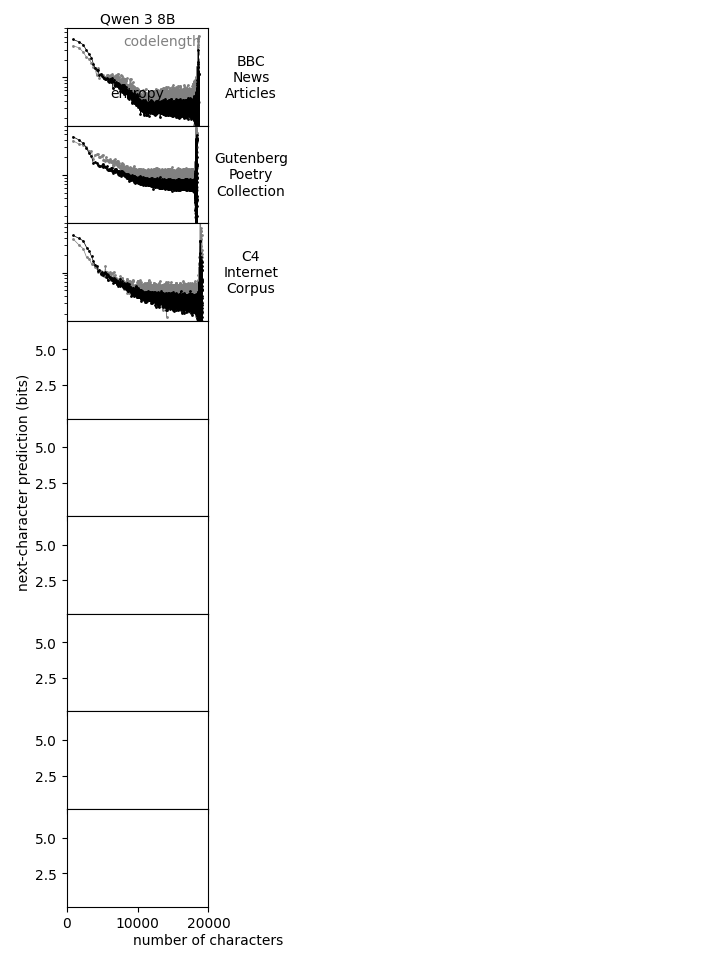

In [ ]:
figh=24/2.54
figw=18/2.54

fig2=plt.figure(figsize=(figw,figh))
axfalse=fig2.add_subplot([0,0,1,1])
axfalse.set_xticks([])
axfalse.set_yticks([])
axfalse.patch.set_visible(False)
axfalse.axis('off')

nrows=len(descriptions)
ncols=1

bbuff=0.05
tbuff=0.02
lbuff=0.08
awidth=0.2
aheight=(1-bbuff-tbuff)/nrows

axes=[]
for j in np.arange(nrows):
    axrow=[]
    for i in np.arange(ncols):
        coordinates=[lbuff+i*awidth,1-tbuff-(j+1)*aheight,awidth,aheight]

        axrow.append(fig2.add_subplot(coordinates))
    axes.append(axrow)
axes=np.array(axes)

fs=10
ts=8
lw=0.5
ms=1


for ax, k in zip(axes[:,0],keys[::-1]):
    v=data['qwen'][k]
    
    msk=v['n']>200
    print(f"Plotting {k} with {v['n'][msk].sum()} samples")
    print(v['n'])
    ax.plot(v['vp'][msk][:]+1,v['e'][msk][:],marker='o',ms=ms, lw=lw,label='entropy', c='k')
    ax.plot(v['vp'][msk][:]+1,v['c'][msk][:],marker='o',ms=ms,lw=lw,label='codelength', c='gray',zorder=-1)
    # # plot all points, no mask
    # ax.plot(v['vp'][:]+1,v['e'][:],marker='o',ms=ms, lw=lw,label='entropy', c='k')
    # ax.plot(v['vp'][:]+1,v['c'][:],marker='o',ms=ms,lw=lw,label='codelength', c='gray',zorder=-1)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.tick_params(axis='both', which='major', labelsize=ts)
    ax.tick_params(axis='both', which='minor', labelsize=ts)
    ax.text(1.3,0.5,descriptions[k],va='center',ha='center',transform=ax.transAxes, fontsize=fs)
    ax.set_yticklabels([])

for ax in axes[:-1,:].flatten():
    ax.set_xticklabels([])

for ax in axes[:,:].flatten():
    ax.set_xlim([0.0,2.0e4])
    ax.set_ylim([0.15,7.0])

# # make ylabels visible
# for ax in axes[0,:].flatten():
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])


axes[0,0].text(0.5,1.02,"Qwen 3 8B",va='bottom',ha='center',transform=axes[0,0].transAxes, fontsize=fs)

axes[0,0].text(0.5,0.4, "entropy", ha='center', va='top', fontsize=fs,transform=axes[0,0].transAxes)
axes[0,0].text(0.95,0.94, "codelength", ha='right', va='top', fontsize=fs, color='gray',transform=axes[0,0].transAxes)

fig2.text(0.01, 0.5, 'next-character prediction (bits)', ha='left', va='center', fontsize=fs, rotation=90)
fig2.text(lbuff+awidth, 0.01, 'number of characters', ha='center', va='baseline', fontsize=fs)
# save as pdf
fig2.savefig('qwen_char.pdf', bbox_inches='tight')

In [16]:
# do the same but for tokens
dataT = {k:{} for k in models}
loadT = {k:{} for k in models}

In [17]:
for model, parent in zip(['qwen'], [parentqwen]):
    temp_load = {}
    for k in keys:
        loaddir = parent+f"{k}/"
        temp_load[k] = loaddata(parent+k+"/")
        
    loadT[f"{model}"] = temp_load

Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/simple/attn/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/simple/entropy_t/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/simple/codelength_t/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/simple/tok/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/wiki/attn/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/wiki/entropy_t/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/wiki/codelength_t/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/wiki/tok/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/BBC/attn/*.npy
Loading 2000 files from /scratch/

In [18]:
for model, parent in zip(['qwen'], [parentqwen]):
    temp_data = {}
    for k in keys:
        print(f"Processing {model} {k}")
        temp_data[k] = takeaverage(loadT[f'{model}'][k])

    dataT[f"{model}"] = temp_data

Processing qwen simple
Processing qwen wiki
Processing qwen BBC
Processing qwen c4
Processing qwen BooksumText
Processing qwen BooksumAnalysis
Processing qwen BookChapter
Processing qwen gpc
Processing qwen poetry


In [19]:
dataT

{'qwen': {'simple': {'e': array([14.00777027,  7.21513348,  5.9683403 , ...,  1.72602486,
           1.68672786,  1.76551456], shape=(2000,)),
   'c': array([13.39934133,  8.12302079,  6.6744989 , ...,  3.24797944,
           2.99553622,  2.63403366], shape=(1999,)),
   'n': array([2000, 2000, 2000, ...,  442,  441,  441], shape=(2000,))},
  'wiki': {'e': array([14.02194127,  7.28196523,  6.12494846, ...,  1.97901658,
           1.96007329,  1.98761564], shape=(2000,)),
   'c': array([13.66957663,  8.70144875,  7.0316017 , ...,  3.19632491,
           3.31873218,  3.2612327 ], shape=(1999,)),
   'n': array([2000, 2000, 2000, ..., 1963, 1963, 1963], shape=(2000,))},
  'BBC': {'e': array([14.05709232,  7.12490665,  6.14148243, ...,  2.15386511,
           2.07779656,  2.30922659], shape=(2000,)),
   'c': array([14.13439281,  9.93803732,  8.1549375 , ...,  3.62242056,
           4.05003692,  3.93158911], shape=(1999,)),
   'n': array([2000, 2000, 2000, ...,  295,  294,  293], shape=(2000,

In [20]:
# save the qwen data and dataT dicts for faster loading next time for plotting
import pickle
with open('qwen_data_char.pkl', 'wb') as f:
    pickle.dump(data, f)
with open('qwen_data_tok.pkl', 'wb') as f:
    pickle.dump(dataT, f)

In [21]:
# also pickle the chars_per_token dict
with open('qwen_chars_per_token.pkl', 'wb') as f:
    pickle.dump(chars_per_token, f)

/tmp/ipykernel_1072635/705319883.py:58: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([0.0,3e3])


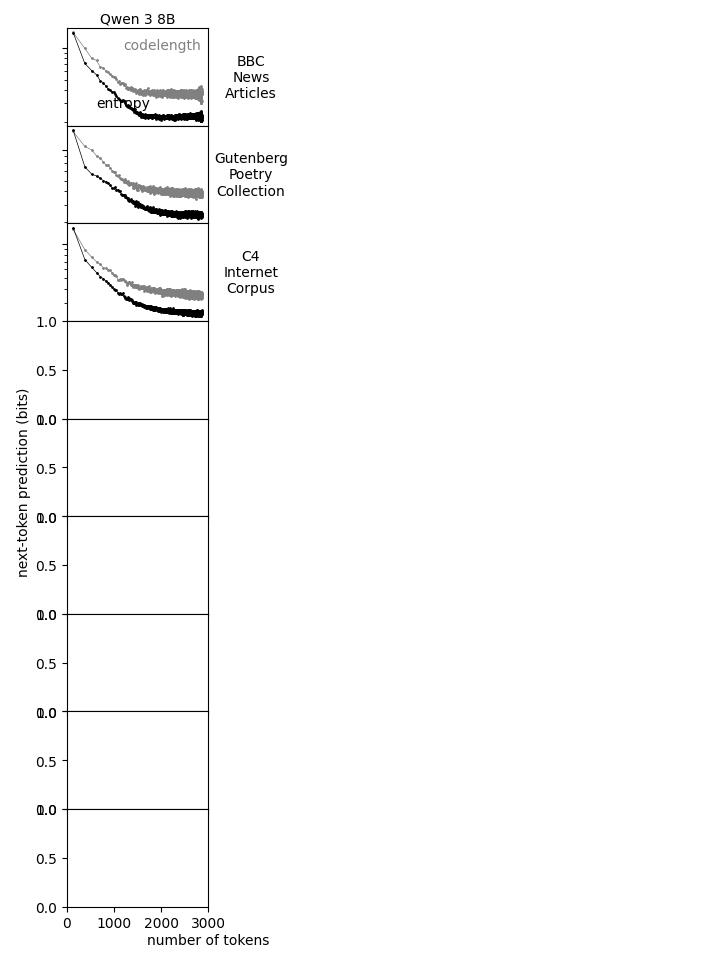

In [ ]:
figh=24/2.54
figw=18/2.54

fig2=plt.figure(figsize=(figw,figh))
axfalse=fig2.add_subplot([0,0,1,1])
axfalse.set_xticks([])
axfalse.set_yticks([])
axfalse.patch.set_visible(False)
axfalse.axis('off')

nrows=len(descriptions)
ncols=1

bbuff=0.05
tbuff=0.02
lbuff=0.08
awidth=0.2
aheight=(1-bbuff-tbuff)/nrows

axes=[]
for j in np.arange(nrows):
    axrow=[]
    for i in np.arange(ncols):
        coordinates=[lbuff+i*awidth,1-tbuff-(j+1)*aheight,awidth,aheight]

        axrow.append(fig2.add_subplot(coordinates))
    axes.append(axrow)
axes=np.array(axes)

fs=10
ts=8
lw=0.5
ms=1


for ax, k in zip(axes[:,0],keys[::-1]):

    v=dataT['qwen'][k]

    xvals=np.arange(len(v['e']))+1
    ax.plot(xvals,v['e'],marker='o',ms=ms, lw=lw,label='entropy', c='k')
    ax.plot(xvals[:-1],v['c'],marker='o',ms=ms,lw=lw,label='codelength', c='gray',zorder=-1)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.tick_params(axis='both', which='major', labelsize=ts)
    ax.tick_params(axis='both', which='minor', labelsize=ts)

    ax.tick_params(which='major',labelleft=True)
    ax.text(1.3,0.5,descriptions[k],va='center',ha='center',transform=ax.transAxes, fontsize=fs)
    ax.set_yticklabels([])
    # add ylabels

for ax in axes[:-1,:].flatten():
    ax.set_xticklabels([])

for ax in axes[:,:].flatten():
    ax.set_xlim([0.0,3e3])
    # ax.set_ylim([2.2,15.0])
    ax.tick_params(which='minor',labelleft=False)

axes[0,0].text(0.5,1.02,"Qwen 3 8B",va='bottom',ha='center',transform=axes[0,0].transAxes, fontsize=fs)

axes[0,0].text(0.4,0.3, "entropy", ha='center', va='top', fontsize=fs,transform=axes[0,0].transAxes)
axes[0,0].text(0.95,0.9, "codelength", ha='right', va='top', fontsize=fs, color='gray',transform=axes[0,0].transAxes)

fig2.text(0.01, 0.5, 'next-token prediction (bits)', ha='left', va='center', fontsize=fs, rotation=90)
fig2.text(lbuff+awidth, 0.01, 'number of tokens', ha='center', va='baseline', fontsize=fs)
# save as pdf
fig2.savefig('qwen_token.pdf', bbox_inches='tight')

NameError: name 'dataT' is not defined

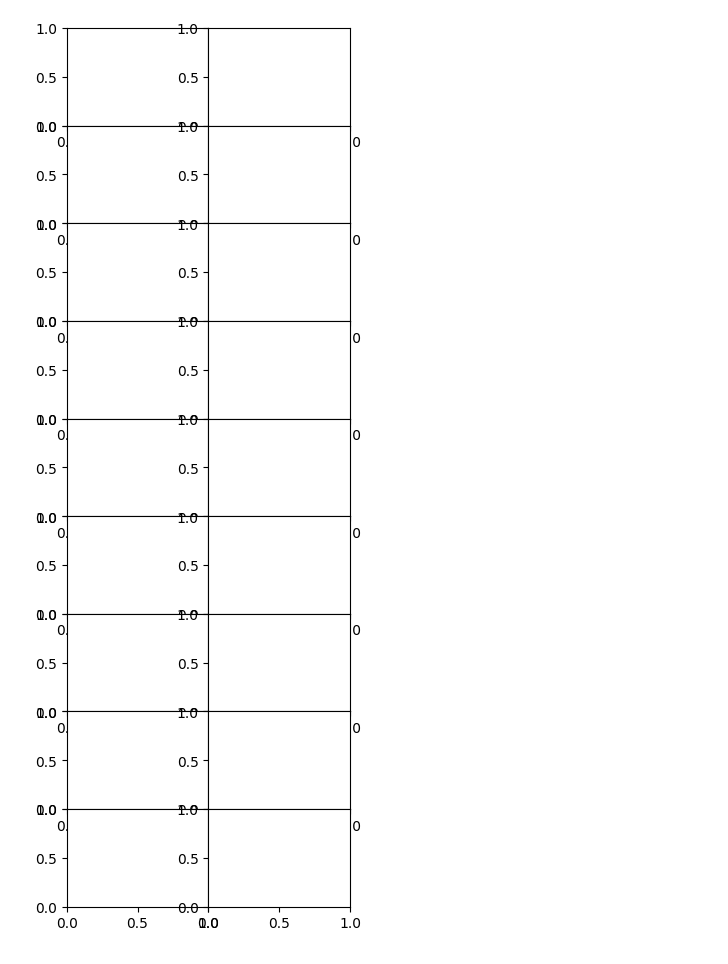

In [ ]:
figh=24/2.54
figw=18/2.54

fig3=plt.figure(figsize=(figw,figh))
axfalse=fig3.add_subplot([0,0,1,1])
axfalse.set_xticks([])
axfalse.set_yticks([])
axfalse.patch.set_visible(False)
axfalse.axis('off')

nrows=len(keys)
ncols=2

bbuff=0.05
tbuff=0.02
lbuff=0.08
awidth=0.2
aheight=(1-bbuff-tbuff)/nrows

axes=[]
for j in np.arange(nrows):
    axrow=[]
    for i in np.arange(ncols):
        coordinates=[lbuff+i*awidth,1-tbuff-(j+1)*aheight,awidth,aheight]
        axrow.append(fig3.add_subplot(coordinates))
    axes.append(axrow)
axes=np.array(axes)

fs=10
ts=8
lw=0.5
ms=1

model_order=['qwen']
for col, model in enumerate(model_order):
    for ax, k in zip(axes[:, col], keys[::-1]):
        cpt = chars_per_token[model][k]
        char_vals = data[model][k]
        token_vals = dataT[model][k]

        char_mask = char_vals['n'] > 200
        char_e_x = (char_vals['vp'][char_mask] + 1) / cpt
        char_c_x = char_e_x[:len(char_vals['c'][char_mask])]

        token_x = np.arange(len(token_vals['e'])) + 1
        ax.plot(token_x, token_vals['e'], marker='o', ms=ms, lw=lw, label='token entropy', c='k')
        ax.plot(token_x[:-1], token_vals['c'], marker='o', ms=ms, lw=lw, label='token codelength', c='gray', zorder=-1)

        ax.plot(char_e_x, char_vals['e'][char_mask], marker='o', ms=ms, lw=lw, ls='--', label='char entropy (scaled)', c='tab:blue')
        ax.plot(char_c_x[:-1], char_vals['c'][char_mask][:-1], marker='o', ms=ms, lw=lw, ls='--', label='char codelength (scaled)', c='tab:orange', zorder=-1)

        ax.set_xscale('log')
        ax.set_yscale('log')

        ax.tick_params(axis='both', which='major', labelsize=ts)
        ax.tick_params(axis='both', which='minor', labelsize=ts)

        ax.text(0.98,0.05,f"{cpt:.2f} chars/token", ha='right', va='bottom', fontsize=ts, transform=ax.transAxes)
        if col==1:
            ax.text(1.3,0.5,descriptions[k],va='center',ha='center',transform=ax.transAxes, fontsize=fs)
            ax.set_yticklabels([])

for ax in axes[:-1,:].flatten():
    ax.set_xticklabels([])

axes[0,0].text(0.5,1.02,"GPT-OSS 20B",va='bottom',ha='center',transform=axes[0,0].transAxes, fontsize=fs)
axes[0,1].text(0.5,1.02,"DCLM 1.7B",va='bottom',ha='center',transform=axes[0,1].transAxes, fontsize=fs)

axes[0,0].text(0.35,0.3, "token entropy", ha='center', va='top', fontsize=fs,transform=axes[0,0].transAxes)
axes[0,0].text(0.82,0.3, "char entropy (scaled)", ha='right', va='top', fontsize=fs, color='tab:blue',transform=axes[0,0].transAxes)

fig3.text(0.01, 0.5, 'prediction (bits)', ha='left', va='center', fontsize=fs, rotation=90)
fig3.text(lbuff+awidth, 0.01, 'tokens (character curves rescaled by mean chars/token)', ha='center', va='baseline', fontsize=fs)

handles, labels = axes[0,0].get_legend_handles_labels()
fig3.legend(handles, labels, loc=(0.32,0.93), ncol=2, fontsize=fs)

fig3.savefig('token_character_rescaled_comparison.pdf', bbox_inches='tight')

In [23]:
# load and save the dclm and olmo data and dataT dicts for faster loading next time for plotting
keys = ["simple", "wiki", "BBC", 'c4','BooksumText','BooksumAnalysis', "BookChapter", "gpc", "poetry"]
models = ['olmo', 'dclm']
data = {k:{} for k in models}
load = {k:{} for k in models}

parentolmo='/scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/'
parentdclm='/scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files_dclm/data/'

# data and load will hold keys for each model: dclm, olmo, oss and the vals are dicts for each model consisting of the keys defined above (dataset names)
# so: dict of dicts of arrays

for model, parent in zip(models, [parentolmo, parentdclm]):
    for k in keys:
        loaddir = parent+f"{k}/"
        load[f"{model}"][k] = loaddataC(parent+k+"/", is_olmo=(model=='olmo'))

for model, parent in zip(models, [parentolmo, parentdclm]):
    temp_data = {}
    for k in keys:
        print(f"Processing {model} {k}")
        temp_data[k] = takeaverageC(load[f'{model}'][k])

    data[f"{model}"] = temp_data    

chars_per_token = {m:{} for m in models}
for model in models:
    for k in keys:
        lengths = load[model][k]['l']
        mask = load[model][k]['m']
        total_chars = (lengths * mask).sum()
        total_tokens = mask.sum()
        chars_per_token[model][k] = float(total_chars / total_tokens)

chars_per_token

# do the same but for tokens
dataT = {k:{} for k in models}
loadT = {k:{} for k in models}

for model, parent in zip(['dclm'], [parentdclm]):
    temp_load = {}
    for k in keys:
        loaddir = parent+f"{k}/"
        temp_load[k] = loaddata(parent+k+"/")
        
    loadT[f"{model}"] = temp_load

for model, parent in zip(['dclm'], [parentdclm]):
    temp_data = {}
    for k in keys:
        print(f"Processing {model} {k}")
        temp_data[k] = takeaverage(loadT[f'{model}'][k])

    dataT[f"{model}"] = temp_data

Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/simple/attn/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/simple/entropy/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/simple/codelength/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/simple/pleak/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/simple/tlens/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/simple/tok/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/wiki/attn/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/wiki/entropy/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/wiki/codelength/*.npy
Loading 2000 files from /scratch/

In [24]:
data

{'olmo': {'simple': {'n': array([543., 545., 518., ...,   1.,   1.,   1.], shape=(10673,)),
   'c': array([2.8761742 , 2.25577511, 1.94955942, ..., 0.04954004, 0.32415363,
          0.        ], shape=(10673,)),
   'e': array([3.57919214, 2.97931747, 2.43182156, ..., 0.24233995, 0.84594703,
          0.08688818], shape=(10673,)),
   'vp': array([    1,     2,     3, ..., 11164, 11172, 11182], shape=(10673,))},
  'wiki': {'n': array([542., 526., 516., ...,   1.,   1.,   1.], shape=(11653,)),
   'c': array([3.00212120e+00, 2.51025533e+00, 2.00943563e+00, ...,
          3.10720119e-04, 1.34323692e+00, 0.00000000e+00], shape=(11653,)),
   'e': array([3.73783056e+00, 3.06609564e+00, 2.42005663e+00, ...,
          3.25149251e-03, 1.17511678e+00, 3.84622097e+00], shape=(11653,)),
   'vp': array([    1,     2,     3, ..., 11907, 11916, 11919], shape=(11653,))},
  'BBC': {'n': array([515., 478., 500., ...,   1.,   1.,   1.], shape=(10270,)),
   'c': array([2.95972418e+00, 2.61245762e+00, 2.0752

In [25]:
dataT

{'olmo': {},
 'dclm': {'simple': {'e': array([10.37295056,  8.20149625,  7.30324799, ...,  3.44035014,
           3.15094405,  3.4126892 ], shape=(1999,)),
   'c': array([11.02463558,  7.9228311 ,  6.77609869, ...,  3.56728607,
           3.58282124,  3.31123476], shape=(1998,)),
   'n': array([2000, 2000, 2000, ...,  423,  421,  420], shape=(1999,))},
  'wiki': {'e': array([10.50113905,  8.19909102,  7.46514015, ...,  3.48305019,
           3.47270748,  3.56163097], shape=(1999,)),
   'c': array([11.50199692,  8.36006463,  7.36908715, ...,  3.69241637,
           3.50110274,  3.53225219], shape=(1998,)),
   'n': array([2000, 2000, 2000, ..., 1963, 1963, 1962], shape=(1999,))},
  'BBC': {'e': array([10.36406971,  8.11032042,  7.23764453, ...,  3.51411755,
           3.40915061,  3.59133824], shape=(1999,)),
   'c': array([11.12763111,  8.34800261,  7.38064218, ...,  3.7183954 ,
           3.76547101,  3.40057489], shape=(1998,)),
   'n': array([2000, 2000, 2000, ...,  495,  493,  492],

In [26]:
chars_per_token

{'olmo': {'simple': 4.441004842113976,
  'wiki': 4.614810615162802,
  'BBC': 4.7315087575072505,
  'c4': 4.79068525,
  'BooksumText': 4.480418759942165,
  'BooksumAnalysis': 4.704050606818006,
  'BookChapter': 4.033749,
  'gpc': 3.92512275,
  'poetry': 4.1616833940087306},
 'dclm': {'simple': 4.3204427602712405,
  'wiki': 4.538547475966953,
  'BBC': 4.545924761351403,
  'c4': 4.652658579289644,
  'BooksumText': 4.413099487071395,
  'BooksumAnalysis': 4.634995208857594,
  'BookChapter': 3.7930947973986995,
  'gpc': 3.59260180090045,
  'poetry': 3.7493240733445146}}

In [27]:
# save data and dataT dicts for olmo and dclm and chars_per_token
import pickle
with open('olmo_dclm_data_char.pkl', 'wb') as f:
    pickle.dump(data, f)
with open('olmo_dclm_data_tok.pkl', 'wb') as f:
    pickle.dump(dataT, f)
with open('olmo_dclm_chars_per_token.pkl', 'wb') as f:
    pickle.dump(chars_per_token, f)